In [101]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [102]:
df=yf.download('NVDA', start='2014-01-01', end='2023-12-31')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,0.398000,0.399500,0.393000,0.396500,0.374024,260092000
2014-01-03,0.397250,0.398000,0.390500,0.391750,0.369543,259332000
2014-01-06,0.395750,0.400000,0.392000,0.397000,0.374496,409492000
2014-01-07,0.401000,0.405000,0.398250,0.403500,0.380627,333288000
2014-01-08,0.405000,0.411000,0.403500,0.409000,0.385816,308192000
...,...,...,...,...,...,...
2023-12-22,49.195000,49.382999,48.466999,48.830002,48.823704,252507000
2023-12-26,48.967999,49.599998,48.959999,49.278999,49.272640,244200000
2023-12-27,49.511002,49.680000,49.084999,49.417000,49.410622,233648000


We have the stock prices of NVIDIA from 2014 to 2023

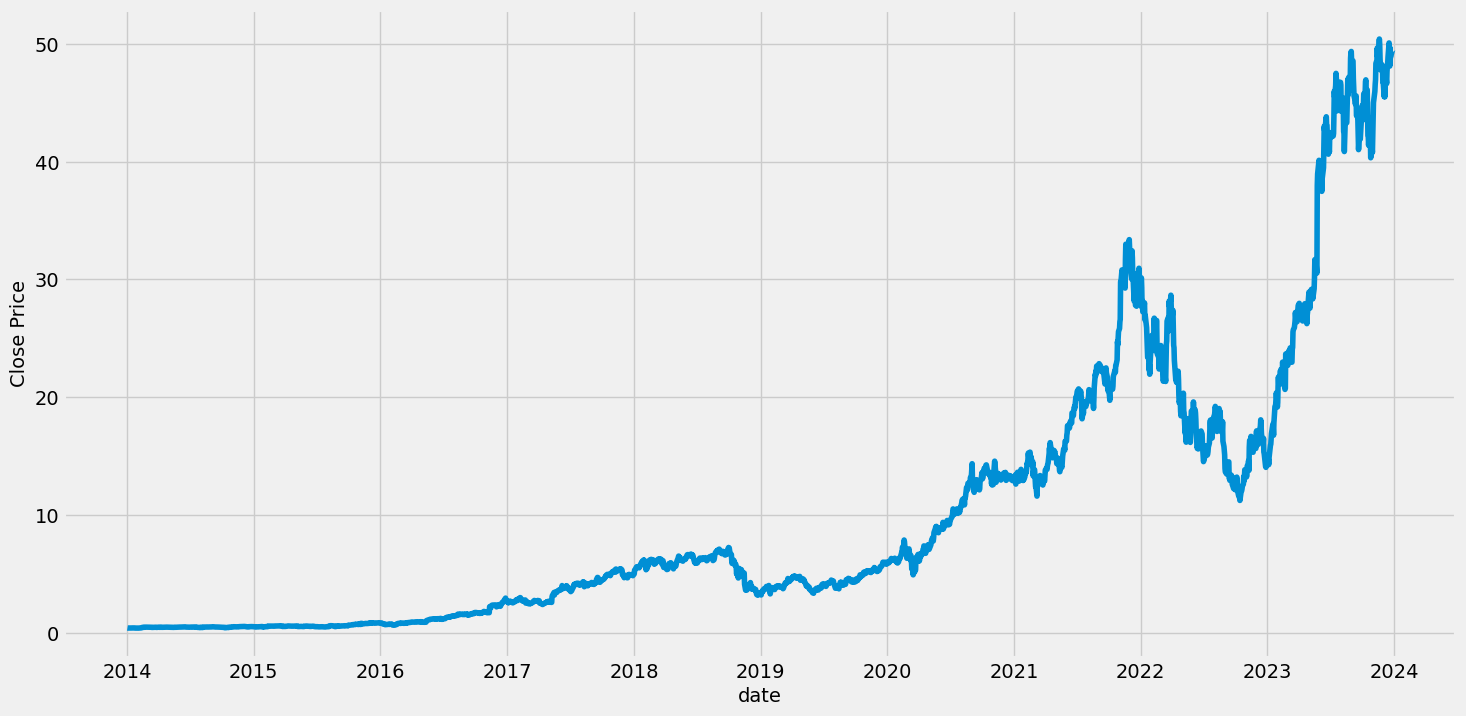

In [103]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.xlabel('date')
plt.ylabel('Close Price')
plt.show()

In [104]:
data=df.filter(['Close'])
dataset=data.values 
dataset.shape

(2516, 1)

In [105]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
scaled_data.shape

(2516, 1)

In [106]:
train_data=scaled_data[0:math.ceil(len(dataset)*0.75),:]
x_train=[]
y_train=[]

for i in range(600,len(train_data)):
    x_train.append(train_data[i-600:i,0])
    y_train.append(train_data[i,0])

train_data.shape

(1887, 1)

In [107]:
x_train,y_train=np.array(x_train),np.array(y_train)
x_train.shape

(1287, 600)

In [108]:
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1287, 600, 1)

In [109]:
model = Sequential()
model.add(Bidirectional(LSTM(32,return_sequences=True,input_shape=(x_train.shape[1],1))))
model.add(Dropout(0.30))
model.add(Bidirectional(LSTM(32,return_sequences=False)))
model.add(Dropout(0.25))
model.add(Dense(16))
model.add(Dropout(0.10))
model.add(Dense(4))
model.add(Dense(1))

In [110]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [111]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=2)
import tensorflow as tf
with tf.device('/CPU:0'):
    m=model.fit(x_train,y_train,batch_size=32, epochs=1)

2024-06-17 10:47:27.246913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 9s 172ms/step - loss: 0.0025


In [112]:
l=math.ceil(len(dataset)*0.75)
print(l)
test_data = scaled_data[l-600:,:]
x_test=[]
y_test=dataset[l:,:]
for i in range(600,len(test_data)):
    x_test.append(test_data[i-600:i,0])
x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_test.shape

1887


(629, 600, 1)

In [113]:
with tf.device('/CPU:0'):
    predictions=model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2024-06-17 10:47:35.368246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 38ms/step


In [114]:
from statsmodels.stats.diagnostic import acorr_ljungbox
residuals= y_test - predictions
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

        lb_stat  lb_pvalue
10  2694.955496        0.0


1.0128295546684811

/var/folders/sq/s3t56nzj13nbwypvfl3nzlth0000gn/T/ipykernel_85999/1882639006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v['predictions']=predictions


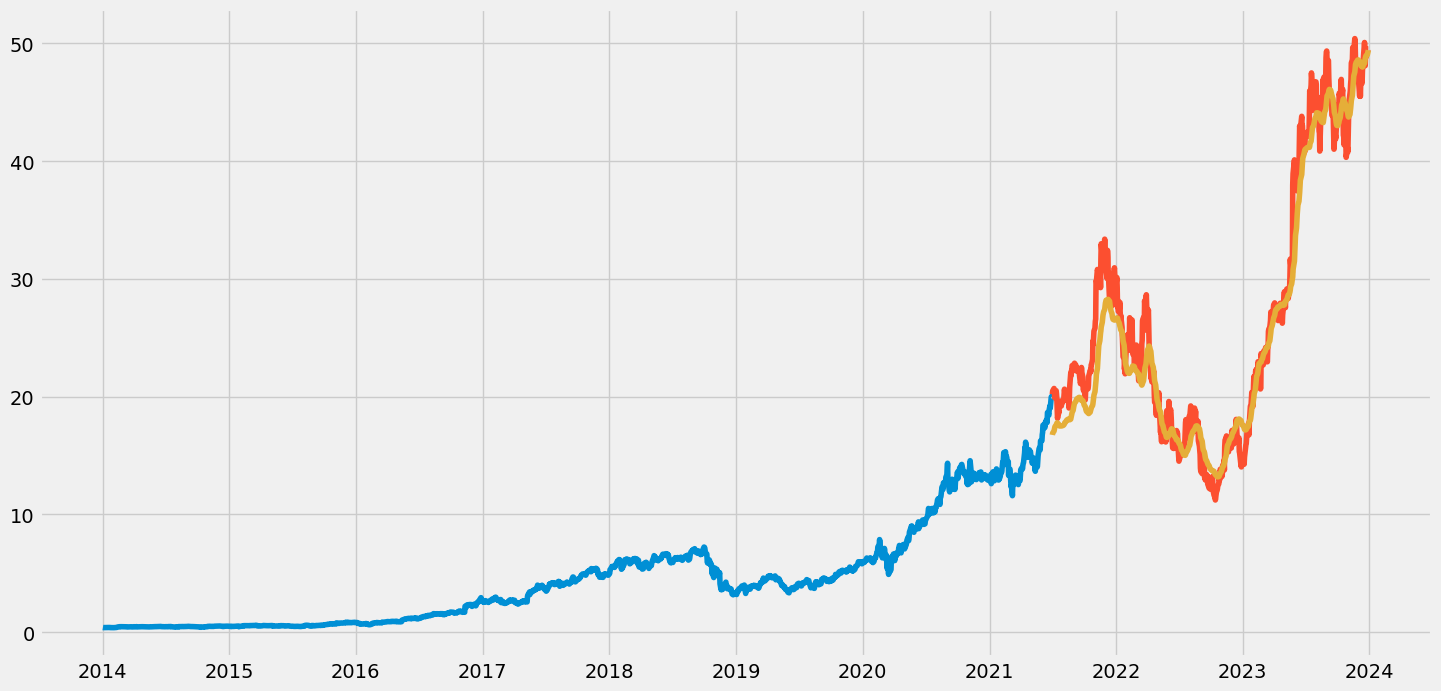

In [115]:
train=data[:l]
v=data[l:]
v['predictions']=predictions
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(v[['Close','predictions']])
plt.show()